# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 2:</center>
### <center> Propiedades en Venta </center>
### <center>  Grupo 18</center>


#### **Integrantes:**

* Analía Acevedo
* Santiago Daniel Marczewski Neudeck
* Lucia Belén Napoli
* Brayan Ricaldi

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.preprocessing as skp

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
from preprocessing import preprocesamiento

from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load

pd.options.display.max_columns = None

from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score, r2_score
from sklearn.datasets import make_regression
from sklearn.datasets import make_classification
from collections import defaultdict
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report

import xgboost as xgb
import plotly.graph_objects as go
%matplotlib inline

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold


Descargo los datos para el modelo 1

In [49]:
_x_train_model1 = pd.read_csv('./DataSet/x_train')
_x_train_model1.drop(columns=['Unnamed: 0'],inplace=True)
_y_train_model1 = pd.read_csv('./DataSet/y_train')
_y_train_model1.drop(columns=['Unnamed: 0'],inplace=True)
_x_test_model1 = pd.read_csv('./DataSet/x_test')
_x_test_model1.drop(columns=['Unnamed: 0'],inplace=True)
_y_test_model1 = pd.read_csv('./DataSet/y_test')
_y_test_model1.drop(columns=['Unnamed: 0'],inplace=True)
_y_train_model1.rename(columns={'0':'pxm2'}, inplace=True)
_y_test_model1.rename(columns={'0':'pxm2'}, inplace=True)

#                                  3. Ensamble de modelos

Construir dos ensambles de modelos de tipo híbridos :

* Ensamble 1: ensamble tipo Voting para el conjunto de datos de clasificación.
Obtener sus métricas y comparar los resultados con los obtenidos en los puntos
anteriores.

* Ensamble 2: ensamble de tipo Stacking combinando diferentes modelos de
regresión y utilizando un modelo adicional para estimar el valor final. Mostrar las
métricas obtenidas y comparar con los resultados obtenidos en los puntos
anteriores.

### Ensamble 1: Vooting


El clasificador de votaciones tiene dos hiperparámetros básicos: estimadores y votaciones. 

El hiperparámetro estimators crea una lista los clasificadores y les asigna nombres. 

El hiperparámetro de votación se establece en "hard" o "soft".

* hard: el clasificador de votación usa las etiquetas de clase predichas para la votación por regla de la mayoría. 

* soft: utilizará un enfoque ponderado para tomar su decisión (predice la etiqueta de clase en función del argmax de las sumas de las probabilidades predichas)

In [50]:
#Ejecutare mis modelos con una copia
x_train = _x_train_model1.copy()
y_train = _y_train_model1.copy()
x_test = _x_test_model1.copy()
y_test = _y_test_model1.copy()

Clasificación de la target del TP1

In [51]:
labels=["bajo","medio","alto"]
new_target_train, bins = pd.qcut(y_train['pxm2'],q=[0,0.25,0.75,1], labels=labels, retbins=True)

Reflejo en test

In [52]:
bins[0] = min(y_test['pxm2']) - 1
bins[3] = max(y_test['pxm2']) + 1

In [53]:
new_target_test = pd.cut(y_test['pxm2'], bins=bins, labels=labels, include_lowest=True)


In [54]:
y_train = new_target_train
y_test = new_target_test

La función make_classification de Scikit-learn es útil para generar conjuntos de datos sintéticos que se pueden usar para probar diferentes algoritmos. El conjunto de datos que generaremos está diseñado para representar un problema de clasificación binaria basado en los siguientes parámetros:

* n_features: la cantidad de features en el conjunto de datos
* n_informative y n_redundant: la cantidad de características informativas y redundantes en el conjunto de datos.
* n_clusters_per_class: el número de clústeres incluidos en cada clase. Los valores más altos hacen que el problema sea más difícil.
* class_sep: controla la separación entre grupos/clases. Los valores más grandes facilitan la tarea.
* flip_y: especifica el porcentaje de etiquetas de clase que se asignarán al azar.Útil para agregar algo de ruido al conjunto de datos.

In [55]:
x_train.head()

,latitud,longitud,ambientes,dormitorios,superficie_cubierta,comuna,Departamento,PH
0,-34.583010,-58.481533,4.0,3.0,70.0,15,1.0,0.0
1,-34.660079,-58.485894,6.0,4.0,275.0,9,0.0,0.0
2,-34.581856,-58.425088,3.0,2.0,97.0,14,1.0,0.0
3,-34.607547,-58.442194,2.0,1.0,42.0,6,1.0,0.0
4,-34.607416,-58.509680,2.0,1.0,38.0,11,1.0,0.0


In [56]:
y_train.head()

0     alto
1     bajo
2    medio
3     bajo
4     alto
Name: pxm2, dtype: category
Categories (3, object): ['bajo' < 'medio' < 'alto']

In [57]:
#Creo un conjunto de datos para entrenar los modelos

x, y = make_classification(n_samples=3000, 
                           n_features=12, 
                           n_informative=7, 
                           n_redundant=5,
                           n_clusters_per_class=5,
                           class_sep=0.7,
                           flip_y=0.03,
                           n_classes=3)

In [58]:
#Creo clasificadores
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

svm_clf = SVC(random_state = 42,probability=True)
knn_clf = KNeighborsClassifier(n_neighbors=6)
arbol_clf= RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('svm', svm_clf), 
                                         ('knn', knn_clf), 
                                         ('arbol', arbol_clf)], 
                                        voting = 'soft')




#Armo conjunto entrenamiento y test 80-20
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, train_size = 0.80)

In [59]:
x_test[0]

array([ 2.8631652 , -0.09904002, -3.62248987,  4.73802179, -1.24052186,
        3.83915568, -2.2919841 , -2.05514369, -0.48257756,  3.60805837,
       -4.89271482, -0.24465958])

In [60]:
y_train[0]

2

In [67]:
# Visualizamos algunas metricas para cada modelo por separado sobre test

list_of_classifiers = [svm_clf, knn_clf, arbol_clf, vot_clf]
# Loop scores
    
for classifier in list_of_classifiers:
    classifier.fit(x_train,y_train)
    y_pred = classifier.predict(x_test)

    print("Model:", classifier.__class__.__name__)
    print("                                      ")
    print("F1 Score:", f1_score(y_test, y_pred, average= 'macro'))
    print("Recall:", recall_score(y_test, y_pred, average= 'macro'))
    print("Precision:", precision_score(y_test, y_pred,average= 'macro'))
    print("Accuracy", accuracy_score(y_test, y_pred))
    
    print("--------------------*-------------------------")

Model: SVC
                                      
F1 Score: 0.6395585742521869
Recall: 0.641701888330235
Precision: 0.6412461268966637
Accuracy 0.64
--------------------*-------------------------
Model: KNeighborsClassifier
                                      
F1 Score: 0.6508772460219084
Recall: 0.6584340217141053
Precision: 0.6596146365355874
Accuracy 0.6533333333333333
--------------------*-------------------------
Model: RandomForestClassifier
                                      
F1 Score: 0.5762100676272867
Recall: 0.5827206824892701
Precision: 0.5833554112954512
Accuracy 0.5783333333333334
--------------------*-------------------------
Model: VotingClassifier
                                      
F1 Score: 0.663419233229234
Recall: 0.6658488772801503
Precision: 0.6662671765640528
Accuracy 0.6633333333333333
--------------------*-------------------------


Accuracy para Voting: 0.6633333333333333


Text(33.0, 0.5, 'True')

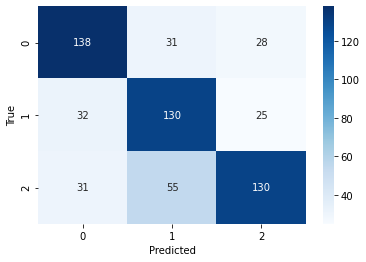

In [68]:
#Entreno el ensamble
vot_clf.fit(x_train, y_train)

#Evaluo en conjunto de test
pred = vot_clf.predict(x_test)
print("Accuracy para Voting:",accuracy_score(y_test, pred))

    
#Matriz de Confusión
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
    

In [69]:
#Reporte de Clasificación
print(classification_report(y_test,pred))




              precision    recall  f1-score   support

           0       0.69      0.70      0.69       197
           1       0.60      0.70      0.65       187
           2       0.71      0.60      0.65       216

    accuracy                           0.66       600
   macro avg       0.67      0.67      0.66       600
weighted avg       0.67      0.66      0.66       600



In [70]:
# Predeccion de probabilidades de clase para todos los clasificadores
probas = [classifier.fit(x_train, y_train).predict_proba(x_train) for classifier in (list_of_classifiers)]

In [71]:
probas[0]

array([[0.15968881, 0.15323192, 0.68707927],
       [0.69318756, 0.22155512, 0.08525732],
       [0.30282444, 0.10266319, 0.59451236],
       ...,
       [0.01552016, 0.38025156, 0.60422828],
       [0.14074973, 0.44686758, 0.41238269],
       [0.07500736, 0.82970084, 0.0952918 ]])

In [72]:
probas[2]

array([[0.2, 0. , 0.8],
       [0.8, 0.2, 0. ],
       [0.1, 0. , 0.9],
       ...,
       [0.1, 0.8, 0.1],
       [0.1, 0.8, 0.1],
       [0.8, 0.2, 0. ]])

TypeError: 'Rectangle' object is not subscriptable

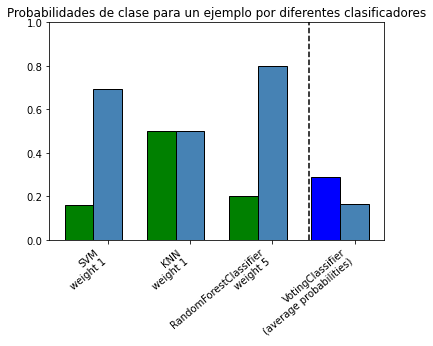

In [73]:

   
# Obtenemos las probabilidades de clase para la primera muestra en el conjunto de datos
class1_1 = [pr[0,0] for pr in probas]
class2_1 = [pr[0,1] for pr in probas]
class3_1 = [pr[1,0] for pr in probas]



# plotting

N = 4  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig, ax = plt.subplots()

# bars for classifier 1-3
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), width,
            color='green', edgecolor='k')

p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width,
            color='lightgreen', edgecolor='k')

p3 = ax.bar(ind + width, np.hstack(([class3_1[:-1], [0]])), width,
            color='steelblue', edgecolor='k')

# bars for VotingClassifier
p4 = ax.bar(ind, [0, 0, 0, class1_1[-1]], width,
            color='blue', edgecolor='k')
p5 = ax.bar(ind + width, [0, 0, 0, class2_1[-1]], width,
            color='steelblue', edgecolor='k')


# plot annotations
plt.axvline(2.8, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
ax.set_xticklabels(['SVM\nweight 1',
                    'KNN\nweight 1',
                    'RandomForestClassifier\nweight 5',
                    'VotingClassifier\n(average probabilities)'],
                   rotation=40,
                   ha='right')


plt.ylim([0, 1])
plt.title('Probabilidades de clase para un ejemplo por diferentes clasificadores')
plt.legend([p1[0], p2[0]],p3[0] ['Alto', 'Bajo','Medio'], loc='upper left')
plt.tight_layout()
plt.show()

# Ensamble 2: Stacking

La idea general del método es entrenar diferentes modelos (modelos base) y un modelo más, que decide, dada una instancia nueva, qué modelo usar. Se utiliza el concepto de meta-aprendizaje para reemplazar el mecanismo de voto.
Para obtener un nivel de referencia de performance y poder compararlo con el ensamble, entrenaremos y evaluaremos individualmente los siguientes modelos base:

* K- vecinos mas cercanos
* Arbol de decisión
* XGBoost

Por otro lado el modelo adicional para estimar el valor final será
* Bosque aleatorio con 50 árboles de decisión (RF).

In [74]:
#Armo conjunto entrenamiento y test 80-20
#Ejecutare mis modelos con una copia obtenida del data set original previamente preprocesado
x_train = _x_train_model1.copy()
y_train = _y_train_model1.copy()
x_test = _x_test_model1.copy()
y_test = _y_test_model1.copy()


Clasificación de la target del TP1

In [75]:
labels=["bajo","medio","alto"]
new_target_train, bins = pd.qcut(y_train['pxm2'],q=[0,0.25,0.75,1], labels=labels, retbins=True)

Reflejo en test

In [76]:
bins[0] = min(y_test['pxm2']) - 1
bins[3] = max(y_test['pxm2']) + 1

In [77]:
new_target_test = pd.cut(y_test['pxm2'], bins=bins, labels=labels, include_lowest=True)


In [78]:
y_train = new_target_train
y_test = new_target_test

La función **make_regression** de Scikit-learn es útil para generar conjuntos de datos sintéticos que se pueden usar para probar diferentes algoritmos. El conjunto de datos que generaremos está diseñado para representar un problema de clasificación binaria basado en los siguientes parámetros:

In [79]:
#Creo un conjunto de datos para entrenar los modelos
x, y = make_regression(n_samples=3000, 
                           n_features=20, 
                           n_informative=15, 
                           random_state= 100)

Cada uno de los modelos se evaluará utilizando una estrategia de validación cruzada de cinco folds repetida dos veces. En cada iteracion cada modelo se entrenó en el 80 % de los datos y se validó en el 20 % restante.

Este método da como resultado 10 puntajes de performance diferentes para cada modelo que almacenaremos en un diccionario.

In [80]:
#Funcion para evaluar los modelos 5fold -CV (repite 2 veces)
def evaluate_model(model, x, y):
    
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=10)
    scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    
    return scores

In [81]:
#Armo conjunto entrenamiento y test 80-20
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 20, train_size = 0.80)

Defino los 3 modelos base que se van a usar para entrenar y evaluar por separado.

In [82]:
#Modelos Base
base_models = {'knn':KNeighborsRegressor(n_neighbors=5,leaf_size=30),
               'arbol': DecisionTreeRegressor(criterion='squared_error',random_state=10),
               'xgbRegressor': xgb.XGBRegressor(random_state = 0)
              }

#Guarda los scores de cada modelo
model_scores = defaultdict()

#Entreno los regresores
for name, model in base_models.items():
  
    print('Evaluando {}'.format(name))
    scores = evaluate_model(model, x_train, y_train)
    model_scores[name] = scores

Evaluando knn


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluando arbol
Evaluando xgbRegressor


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.1s finished


Defino ahora el meta modelo que será en este caso un Random Forest

In [83]:
from sklearn.ensemble import StackingRegressor

#Modelos Base
base_models = [('knn', KNeighborsRegressor(n_neighbors=5,leaf_size=30)),
               ('arbol', DecisionTreeRegressor(criterion='squared_error',random_state=10)),
               ('xgbRegressor', xgb.XGBRegressor(random_state = 0))]

#Meta Modelo
meta_model = RandomForestRegressor()

#Ensemble Stacking
stacking_model = StackingRegressor(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)

Vamos a verificar la performance del meta modelo y guardar sus scores.

In [84]:
#Performance el modelo en entrenamiento
stacking_scores = evaluate_model(stacking_model, x_train, y_train)
model_scores['stacking'] = stacking_scores

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   19.1s finished


La función plot_regression_results se usa para trazar los objetivos predichos y verdaderos.

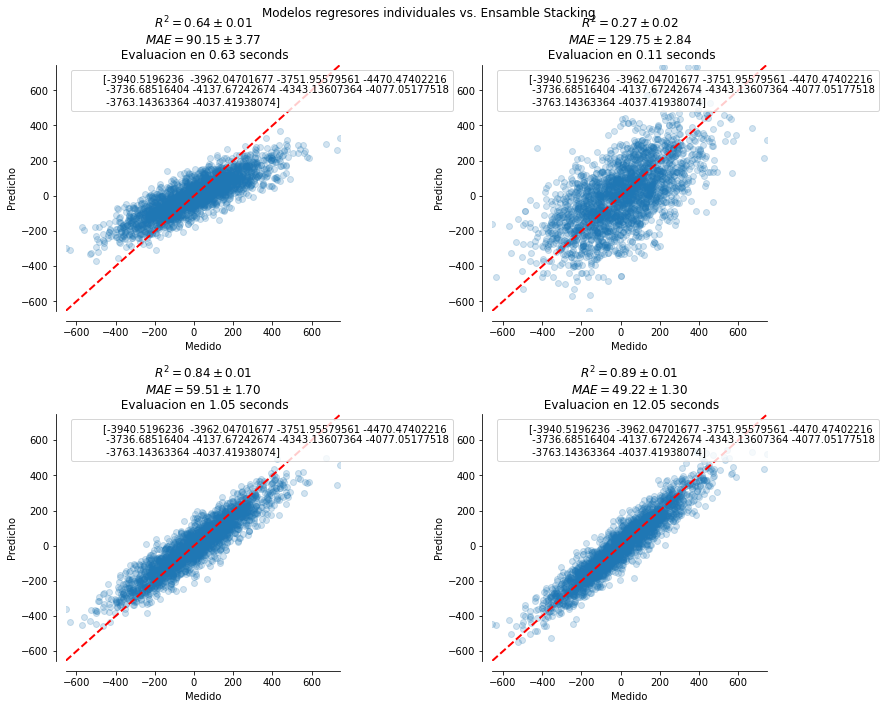

In [85]:
import time
from sklearn.model_selection import cross_validate, cross_val_predict


def plot_regression_results(ax, y_test, y_pred_st, title, stacking_scores, elapsed_time):
    """Scatter plot de los objetivos predichos y verdaderos."""
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--r", linewidth=2)
    ax.scatter(y_test, y_pred_st, alpha=0.2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_test.min(), y_test.max()])
    ax.set_ylim([y_test.min(), y_test.max()])
    ax.set_xlabel("Medido")
    ax.set_ylabel("Predicho")
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=8
    )
    ax.legend([extra], [stacking_scores], loc="upper left")
    title = title + "\n Evaluacion en {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = np.ravel(axs)

for ax, (name, stacking_model) in zip(
    axs, base_models + [("Stacking Regressor", stacking_model)]
):
    start_time = time.time()
    score = cross_validate(stacking_model, x_train, y_train, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred_st = cross_val_predict(stacking_model, x_train, y_train, n_jobs=2, verbose=0)

    plot_regression_results(ax, y_train,y_pred_st,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),stacking_scores,elapsed_time)

plt.suptitle("Modelos regresores individuales vs. Ensamble Stacking")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [86]:
#Evaluo en conjunto de test
from sklearn.metrics import mean_absolute_error
#stacking_model.fit(x_train,y_train).score(x_test,y_test)
stacking_model.fit(x_train,y_train)
y_pred_st = stacking_model.predict(x_test)

print("Métricas para el modelo Stacking predictor final:")
print("MAE", mean_absolute_error(y_test, y_pred_st))
print("MSE", mean_squared_error(y_test, y_pred_st))
print("R2", r2_score(y_test, y_pred_st))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


Métricas para el modelo Stacking predictor final:
MAE 48.681384321346805
MSE 3942.9315664617593
R2 0.8862828409740368


Utilizamos la métrica del Error Absoluto Medio que consiste en la sumatoria de la diferencia de los errores..En los gráficos podemos observar que el ensamble tiene un MAE de 48.681384321346805 y es el más bajo respecto a cada uno de los modelos regresores individuales KNN, Arbol de decisión y XGBoost
